In [1]:
library(ALDEx2)
library(ggplot2)
library(reshape2)
library(dada2)
library(patchwork)
library(DirichletMultinomial)
library(Biostrings)
library(phyloseq)
library(MASS)
library(fitdistrplus)

Loading required package: zCompositions

Warning message:
"package 'zCompositions' was built under R version 4.3.3"
Loading required package: MASS

Loading required package: NADA

Warning message:
"package 'NADA' was built under R version 4.3.3"
Loading required package: survival


Attaching package: 'NADA'


The following object is masked from 'package:stats':

    cor


Loading required package: truncnorm

Warning message:
"package 'truncnorm' was built under R version 4.3.3"
Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 4.3.3"
Loading required package: latticeExtra

Warning message:
"package 'latticeExtra' was built under R version 4.3.3"

Attaching package: 'ggplot2'


The following object is masked from 'package:latticeExtra':

    layer


Warning message:
"package 'reshape2' was built under R version 4.3.3"
Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.3.3"
Warning message:
"package 

In [2]:
taxa_hetero1 <- readRDS("taxa_silva_hetero1.rds")
taxa_oc1     <- readRDS("taxa_silva_oc1.rds")
phylo_hetero1 <- readRDS("phyloseq_object_hetero1.rds")
phylo_oc1     <- readRDS("phyloseq_object_oc_phase1.rds")
taxa_od_wgs   <- read.table("merged_absolute_abundance_od1.tsv", sep = "\t", header = TRUE, row.names = 1)
taxa_oc_wgs   <- read.table("merged_absolute_abundance_oc1.tsv", sep = "\t", header = TRUE, row.names = 1)
taxa_hetero_wgs   <- read.table("merged_absolute_abundance_hetero1.tsv", sep = "\t", header = TRUE, row.names = 1)
seqtab.nochim_oc     <- readRDS("seqtab.nochim_oc.rds")
seqtab.nochim_hetero <- readRDS("seqtab.nochim_hetero.rds")

In [3]:
make_taxonomy_abundance_df <- function(ps, rank_prefixes = c("K", "P", "C", "O", "F", "G")) {
  otu_df <- as.data.frame(otu_table(ps))
  tax_df <- as.data.frame(tax_table(ps))

  if (taxa_are_rows(ps)) otu_df <- t(otu_df)

  shared_taxa <- intersect(colnames(otu_df), rownames(tax_df))
  otu_df <- otu_df[, shared_taxa, drop = FALSE]
  tax_df <- tax_df[shared_taxa, , drop = FALSE]

  tax_df[is.na(tax_df)] <- "unclassified"
  tax_labels <- apply(tax_df, 1, function(row) paste(paste0(rank_prefixes, ":_", row), collapse = "|"))
  colnames(otu_df) <- tax_labels

  return(as.data.frame(otu_df))
}

# Low-abundance Filter
filter_low_abundance <- function(df, min_count = 5, min_prevalence = 0.1) {
  prevalence <- rowSums(df > min_count) / ncol(df)
  df[prevalence >= min_prevalence, , drop = FALSE]
}

# ALDEx2 CLR Transformation
run_aldex_normalization <- function(abundance, cond_label = "default", seed = 42) {
  set.seed(seed)
  abundance[is.na(abundance)] <- 0
  abundance <- abundance[rowSums(abundance) > 0, , drop = FALSE]
  conds <- rep("heterogenic", ncol(abundance))
  aldex_clr <- aldex.clr(abundance, conds = conds, mc.samples = 128, denom = "all", verbose = TRUE)
  clr_matrix <- do.call(cbind, lapply(aldex_clr@analysisData, rowMeans))
  colnames(clr_matrix) <- colnames(abundance)
  rownames(clr_matrix) <- rownames(abundance)
  return(clr_matrix)
}

In [4]:
ps_oc <- phyloseq(otu_table(seqtab.nochim_oc, taxa_are_rows = FALSE), tax_table(taxa_oc1))
ps_hetero <- phyloseq(otu_table(seqtab.nochim_hetero, taxa_are_rows = FALSE), tax_table(taxa_hetero1))

# Add ASV names
taxa_names(ps_oc)     <- paste0("ASV", seq(ntaxa(ps_oc)))
taxa_names(ps_hetero) <- paste0("ASV", seq(ntaxa(ps_hetero)))

# Taxonomic Abundance Tables
tax_abund_oc     <- t(make_taxonomy_abundance_df(ps_oc))
tax_abund_hetero <- t(make_taxonomy_abundance_df(ps_hetero))

In [5]:
taxa_od_wgs_filtered      <- filter_low_abundance(taxa_od_wgs)
taxa_oc_wgs_filtered      <- filter_low_abundance(taxa_oc_wgs)
tax_abund_oc_filtered     <- filter_low_abundance(tax_abund_oc)
tax_abund_hetero_filtered <- filter_low_abundance(tax_abund_hetero)
tax_abund_hetero_wgs_filtered <- filter_low_abundance(taxa_hetero_wgs)

In [6]:
clr_od_wgs_raw          <- run_aldex_normalization(as.matrix(taxa_od_wgs), "raw_ocean_deep")
clr_oc_wgs_raw          <- run_aldex_normalization(as.matrix(taxa_oc_wgs), "raw_ocean_coastal")
clr_oc_amplicon_raw     <- run_aldex_normalization(as.matrix(tax_abund_oc), "raw_oc_amplicon")
clr_hetero_amplicon_raw <- run_aldex_normalization(as.matrix(tax_abund_hetero), "raw_hetero_amplicon")
clr_hetero_wgs_raw <- run_aldex_normalization(as.matrix(taxa_hetero_wgs), "raw_hetero_wgs")

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete



In [ ]:
clr_od_wgs          <- run_aldex_normalization(taxa_od_wgs_filtered, "ocean_deep")
clr_oc_wgs          <- run_aldex_normalization(taxa_oc_wgs_filtered, "ocean_coastal")
clr_oc_amplicon     <- run_aldex_normalization(tax_abund_oc_filtered, "ocean_coastal_amp")
clr_hetero_amplicon <- run_aldex_normalization(tax_abund_hetero_filtered, "hetero_amp")
clr_hetero_wgs  <- run_aldex_normalization(tax_abund_hetero_wgs_filtered, "hetero_wgs")

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete



In [8]:
plot_clr_boxplot <- function(clr_matrix, title_prefix = "") {
  clr_long <- melt(clr_matrix, varnames = c("Feature", "Sample"), value.name = "CLR_Value")
  p <- ggplot(clr_long, aes(x = Sample, y = CLR_Value)) +
    geom_boxplot(outlier.size = 0.5) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = paste0(title_prefix, ": CLR Abundances per Sample"),
         y = "CLR Abundance", x = "Sample")
  return(p)
}

In [9]:
plot_clr_mean_variance <- function(clr_matrix, title_prefix = "") {
  clr_means <- rowMeans(clr_matrix)
  clr_vars  <- apply(clr_matrix, 1, var)
  p <- ggplot(data.frame(mean = clr_means, var = clr_vars), aes(x = mean, y = var)) +
    geom_point(color = "blue", size = 1) +
    scale_x_log10() + scale_y_log10() +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Mean-Variance Plot"),
         x = "Mean CLR Abundance", y = "Variance")
  return(p)
}

In [10]:
plot_combined_mv <- function(clr_list, n = 10, seed = 123, title = "Mean vs Variance Plot (Subsampled)") {
  set.seed(seed)
  
  mv_df <- data.frame()

  for (domain_name in names(clr_list)) {
    clr_matrix <- clr_list[[domain_name]]
    
    # Subsample up to n samples per domain
    sample_subset <- sample(colnames(clr_matrix), min(n, ncol(clr_matrix)))
    clr_sub <- clr_matrix[, sample_subset, drop = FALSE]
    
    # Compute per-feature mean and variance (rows = features)
    feature_means <- rowMeans(clr_sub)
    feature_vars  <- apply(clr_sub, 1, var)

    mv_domain_df <- data.frame(
      Feature = rownames(clr_sub),
      Mean = feature_means,
      Variance = feature_vars,
      Domain = domain_name
    )
    
    mv_df <- rbind(mv_df, mv_domain_df)
  }
  
  ggplot(mv_df, aes(x = Mean, y = Variance, color = Domain)) +
    geom_point(alpha = 0.6, size = 2) +
    theme_minimal() +
    labs(title = title, x = "Mean CLR Abundance (per Feature)", y = "Variance (per Feature)") +
    scale_color_brewer(palette = "Set1") +
    theme(legend.title = element_text(size = 10),
          legend.text = element_text(size = 9))
}


In [11]:
library(ggplot2)
library(fitdistrplus)
library(MASS)
library(stringr)

plot_all_distributions <- function(clr_matrix, env_name = "") {
  v <- as.vector(clr_matrix)
  v <- v[!is.na(v)]
  v_pos <- v[v > 0]
  n <- length(v_pos)
  probs <- ppoints(n)
  plots <- list()
  
  base_theme <- theme_bw(base_size = 8) +
    theme(plot.title = element_text(size = 10, face = "bold", hjust = 0.5))
  
  title_fmt <- function(dist_name) {
    paste0(str_wrap(env_name, 28), "\n", dist_name)
  }
  
  # Normal
  plots[["Normal"]] <- ggplot(data.frame(sample = sort(v_pos),
                                         theoretical = qqnorm(v_pos, plot.it = FALSE)$x),
                              aes(sample = sample)) +
    stat_qq() + stat_qq_line(col = "red") +
    base_theme +
    labs(title = title_fmt("Normal"), x = "Theoretical", y = "Sample")
  
  # Poisson
  lambda <- mean(v_pos)
  theo_pois <- qpois(probs, lambda)
  plots[["Poisson"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_pois)),
                               aes(x = theoretical, y = sample)) +
    geom_point(size = 1) + geom_abline(slope = 1, intercept = 0, col = "red") +
    base_theme +
    labs(title = title_fmt("Poisson"), x = "Theoretical", y = "Sample")
  
  # Log-Normal
  log_v <- log(v_pos)
  plots[["LogNormal"]] <- ggplot(data.frame(sample = sort(log_v),
                                            theoretical = qqnorm(log_v, plot.it = FALSE)$x),
                                 aes(sample = sample)) +
    stat_qq() + stat_qq_line(col = "red") +
    base_theme +
    labs(title = title_fmt("Log-Normal"), x = "Theoretical", y = "Log Sample")
  
  # Negative Binomial
  nb_fit <- tryCatch(fitdistr(round(v_pos), "Negative Binomial"), error = function(e) NULL)
  if (!is.null(nb_fit)) {
    size <- nb_fit$estimate["size"]
    mu <- nb_fit$estimate["mu"]
    theo_nb <- qnbinom(probs, size = size, mu = mu)
    plots[["NegBinom"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_nb)),
                                  aes(x = theoretical, y = sample)) +
      geom_point(size = 1) + geom_abline(slope = 1, intercept = 0, col = "red") +
      base_theme +
      labs(title = title_fmt("NB"), x = "Theoretical", y = "Sample")
  }
  
  # Gamma
  shape <- mean(v_pos)^2 / var(v_pos)
  rate <- mean(v_pos) / var(v_pos)
  theo_gamma <- qgamma(probs, shape = shape, rate = rate)
  plots[["Gamma"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_gamma)),
                             aes(x = theoretical, y = sample)) +
    geom_point(size = 1) + geom_abline(slope = 1, intercept = 0, col = "red") +
    base_theme +
    labs(title = title_fmt("Gamma"), x = "Theoretical", y = "Sample")
  
  # Log-Cauchy
  cauchy_fit <- tryCatch(fitdist(log_v, "cauchy"), error = function(e) NULL)
  if (!is.null(cauchy_fit)) {
    location <- cauchy_fit$estimate["location"]
    scale <- cauchy_fit$estimate["scale"]
    theo_lc <- qcauchy(probs, location, scale)
    plots[["LogCauchy"]] <- ggplot(data.frame(sample = sort(log_v), theoretical = sort(theo_lc)),
                                   aes(x = theoretical, y = sample)) +
      geom_point(size = 1) + geom_abline(slope = 1, intercept = 0, col = "red") +
      base_theme +
      labs(title = title_fmt("Log-Cauchy"), x = "Theoretical", y = "Log Sample")
  }
  
  # Weibull
  weibull_fit <- tryCatch(fitdist(v_pos, "weibull"), error = function(e) NULL)
  if (!is.null(weibull_fit)) {
    shape_w <- weibull_fit$estimate["shape"]
    scale_w <- weibull_fit$estimate["scale"]
    theo_weibull <- qweibull(probs, shape = shape_w, scale = scale_w)
    plots[["Weibull"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_weibull)),
                                 aes(x = theoretical, y = sample)) +
      geom_point(size = 1) + geom_abline(slope = 1, intercept = 0, col = "red") +
      base_theme +
      labs(title = title_fmt("Weibull"), x = "Theoretical", y = "Sample")
  }
  
  return(plots)
}


Warning message:
"package 'stringr' was built under R version 4.3.3"


 # Mean vs variance with normalization before filtration

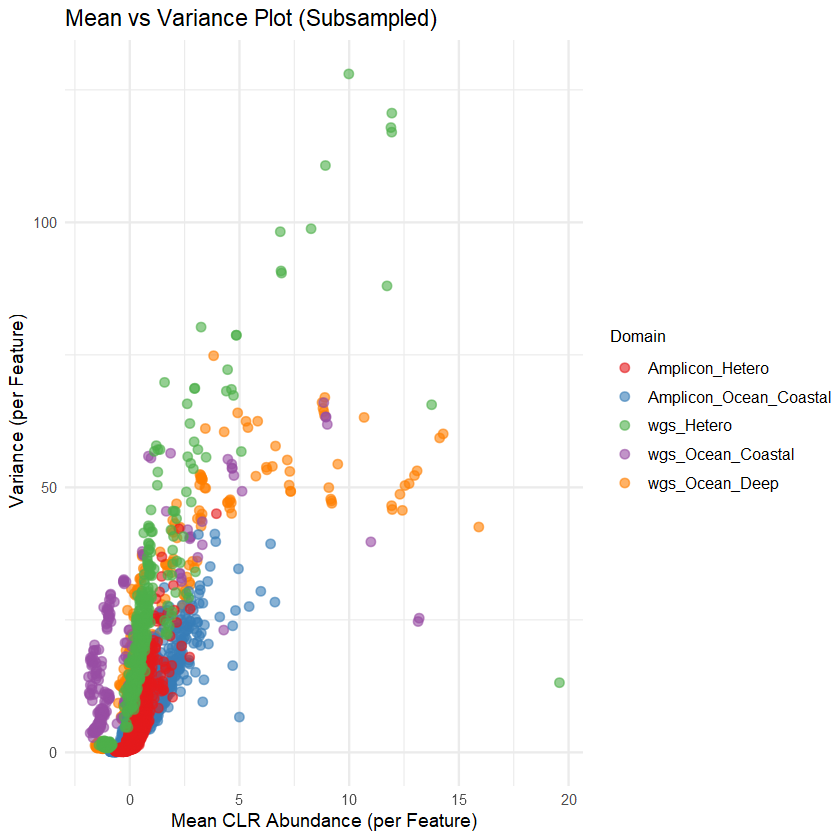

In [13]:
raw_list_filtered <- list(
  wgs_Ocean_Deep = clr_od_wgs_raw,
  wgs_Ocean_Coastal = clr_oc_wgs_raw,
  Amplicon_Ocean_Coastal = clr_oc_amplicon_raw,
  Amplicon_Hetero = clr_hetero_amplicon_raw,
  wgs_Hetero = clr_hetero_wgs_raw
)

plot_combined_mv(raw_list_filtered)

# Mean vs variance without normalization before filtration

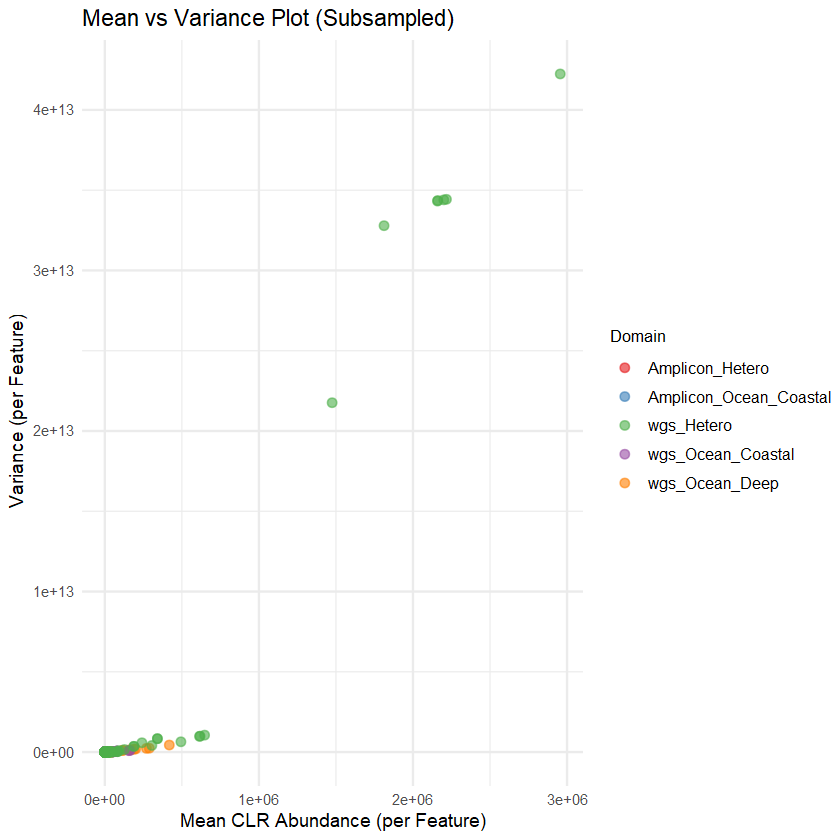

In [14]:
raw_list_non_filtered <- list(
  wgs_Ocean_Deep = taxa_od_wgs,
  wgs_Ocean_Coastal = taxa_oc_wgs,
  Amplicon_Ocean_Coastal = tax_abund_oc,
  Amplicon_Hetero = tax_abund_hetero,
  wgs_Hetero = taxa_hetero_wgs
)

plot_combined_mv(raw_list_non_filtered)

# Mean vs variance after filtration and normalization

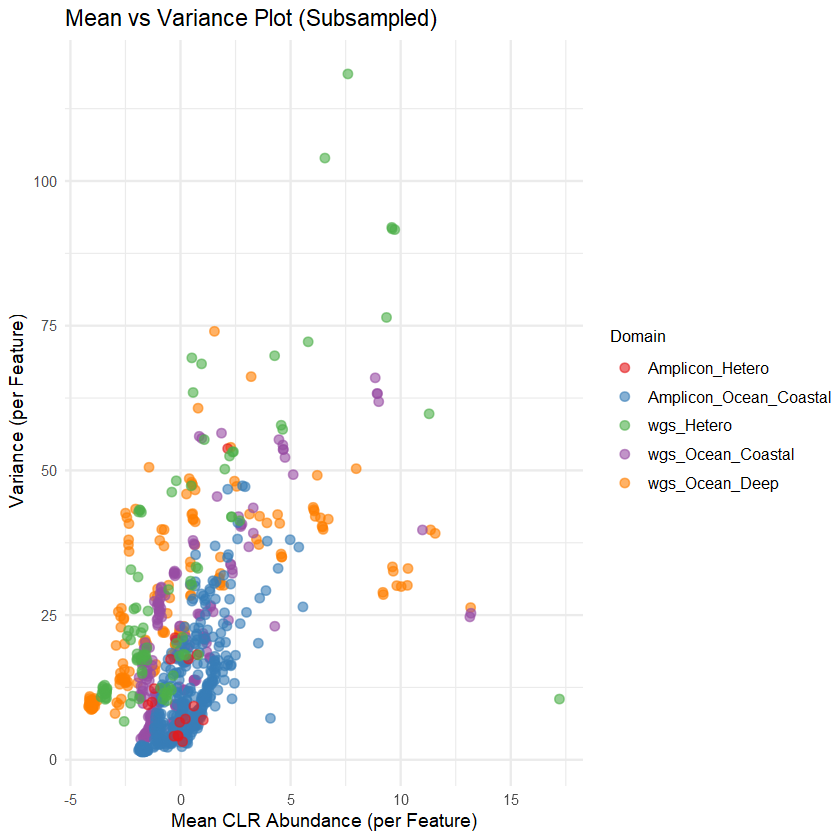

In [16]:
clr_list_filtered <- list(
  wgs_Ocean_Deep = clr_od_wgs_filtered,
  wgs_Ocean_Coastal = clr_oc_wgs_filtered,
  Amplicon_Ocean_Coastal = clr_oc_amp_filtered,
  Amplicon_Hetero = clr_hetero_amp_filtered,
  wgs_Hetero = clr_hetero_wgs
)

plot_combined_mv(clr_list_filtered)

# q-q for non- filtered and non-normalized

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


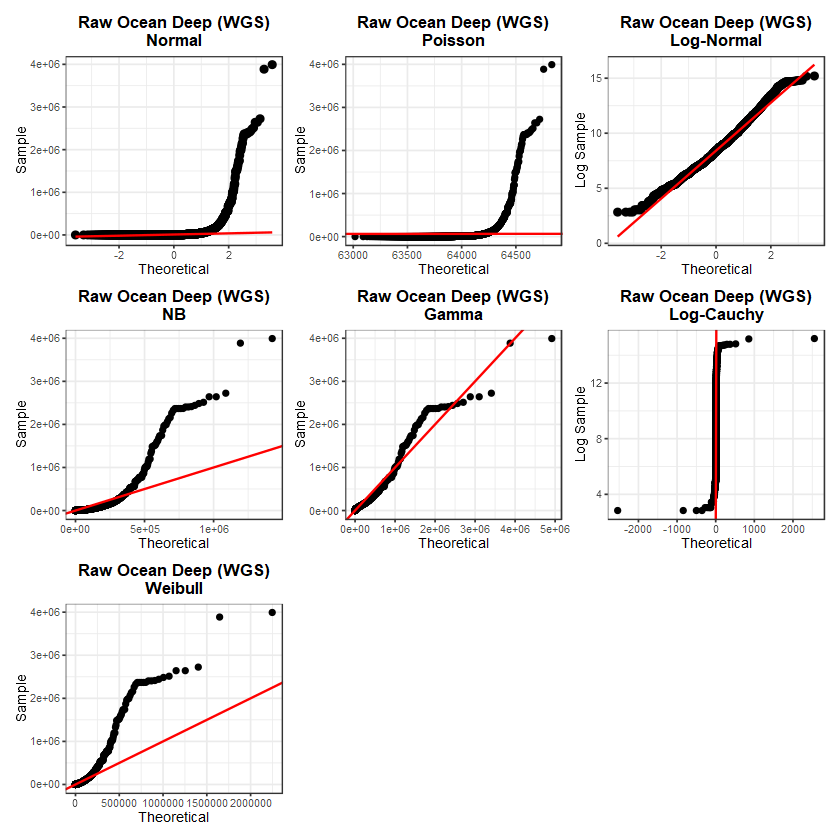

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


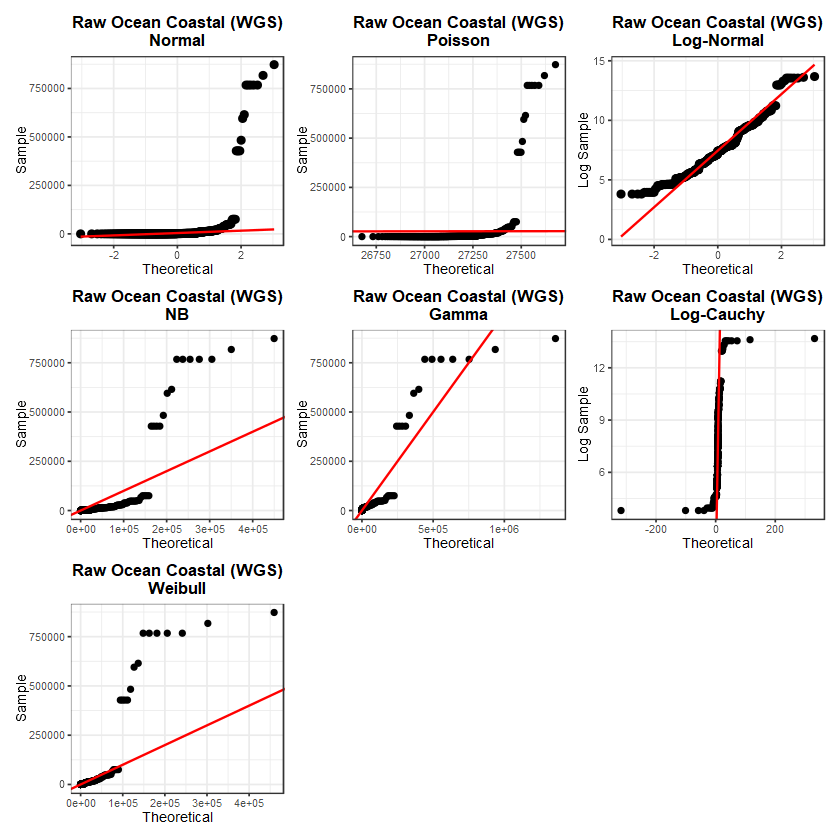

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


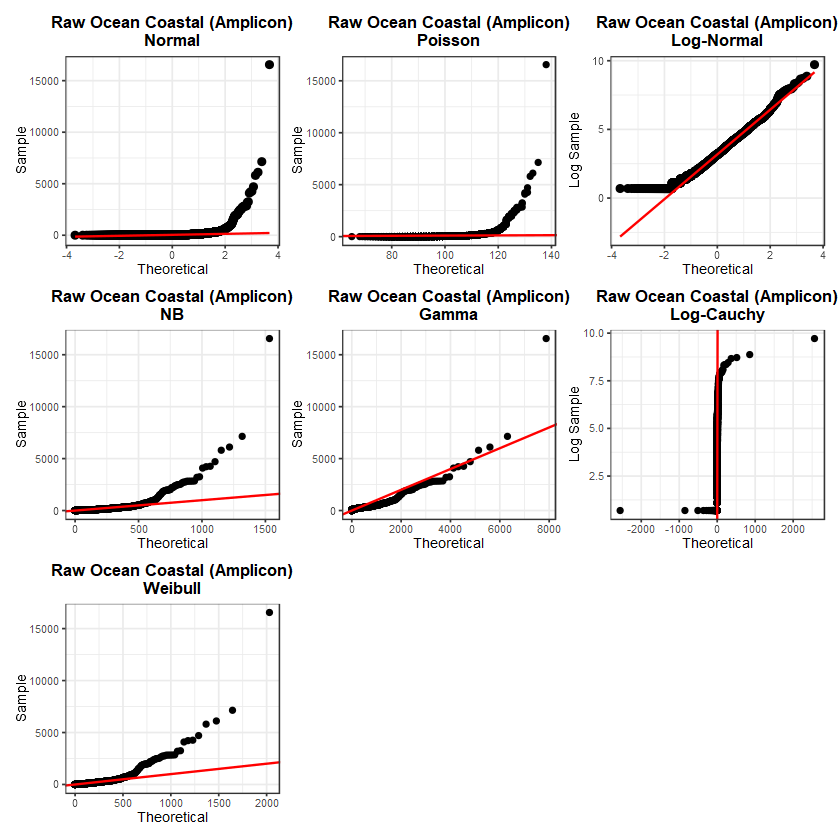

Warning message in sqrt(1/diag(V)):
"NaNs produced"
Warning message in cov2cor(varcovar):
"diag(.) had 0 or NA entries; non-finite result is doubtful"
Warning message in sqrt(diag(varcovar)):
"NaNs produced"


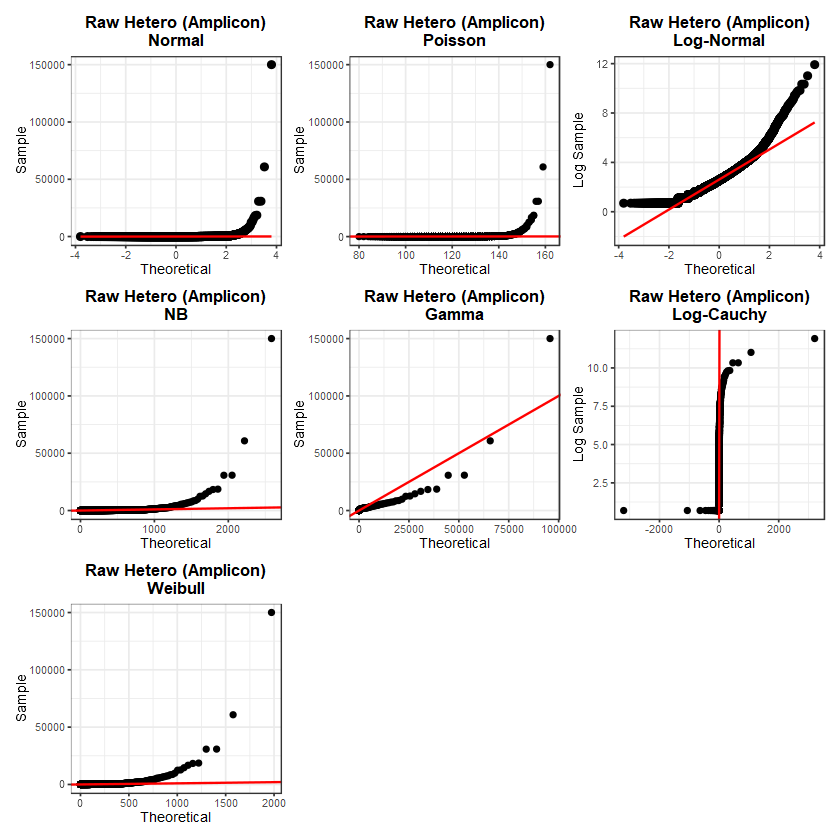

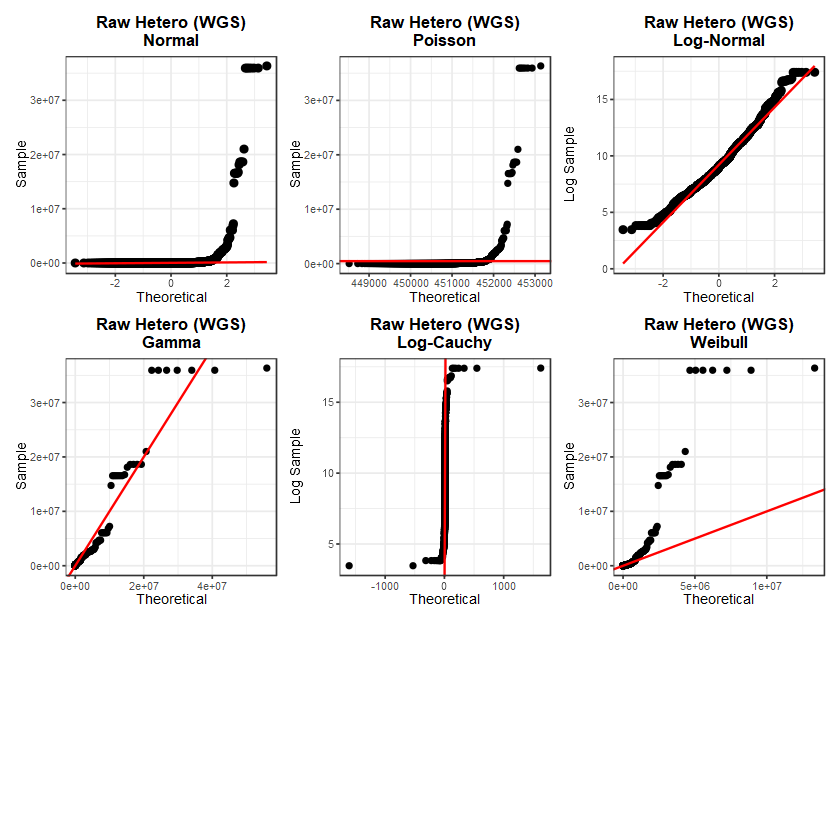

In [18]:
wrap_plots(plot_all_distributions(as.matrix(taxa_od_wgs), "Raw Ocean Deep (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(taxa_oc_wgs), "Raw Ocean Coastal (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(tax_abund_oc), "Raw Ocean Coastal (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(tax_abund_hetero), "Raw Hetero (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(taxa_hetero_wgs), "Raw Hetero (WGS)"), ncol = 3, nrow = 3)



# q-q plots for data filtered but not normalized

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


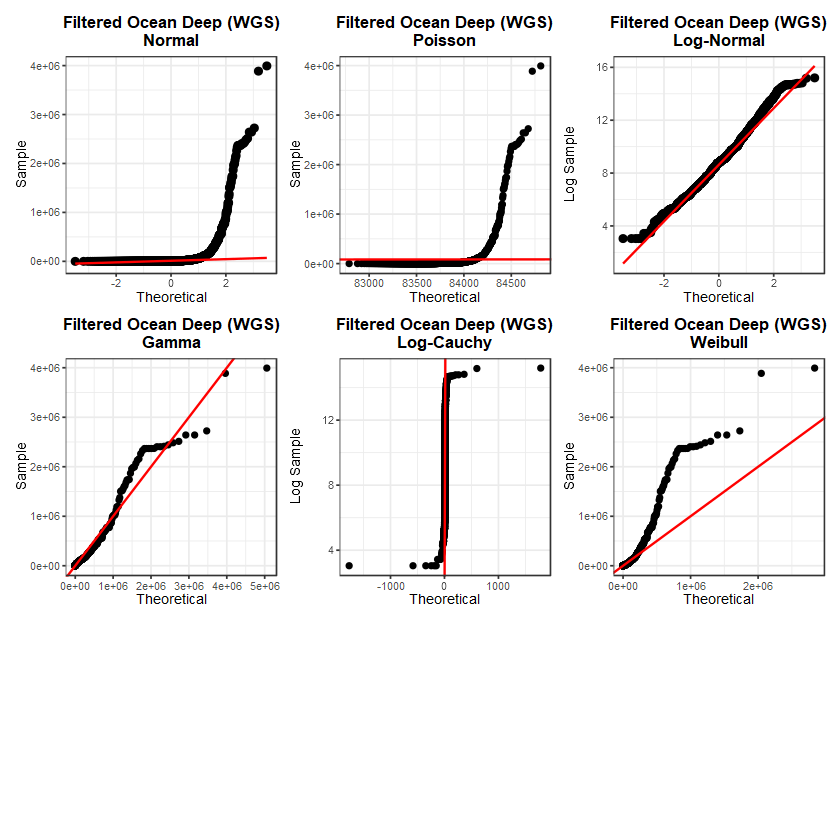

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


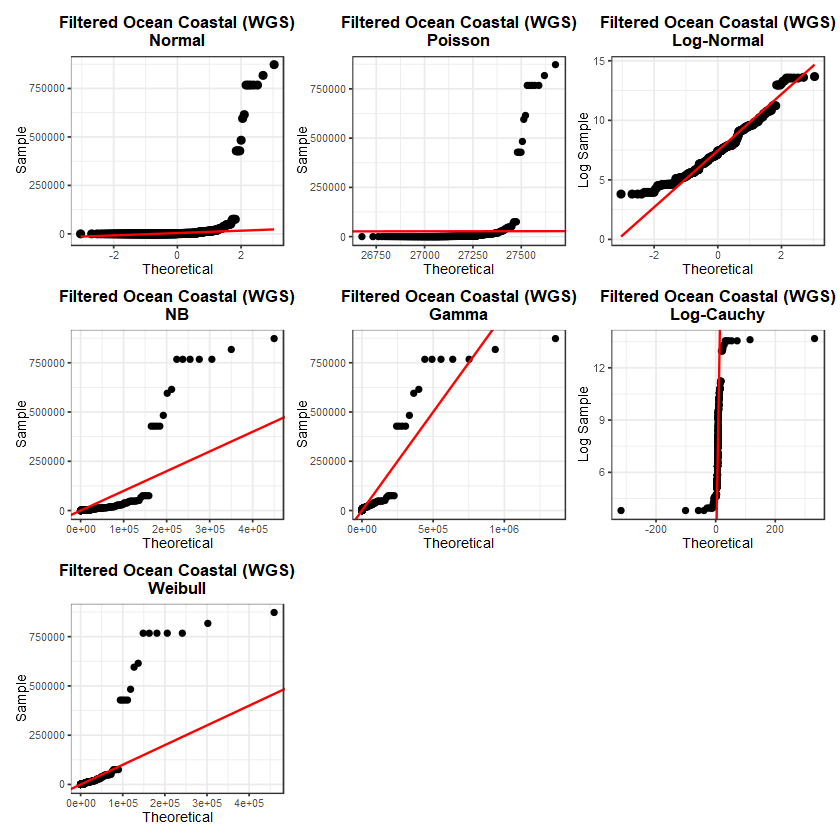

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


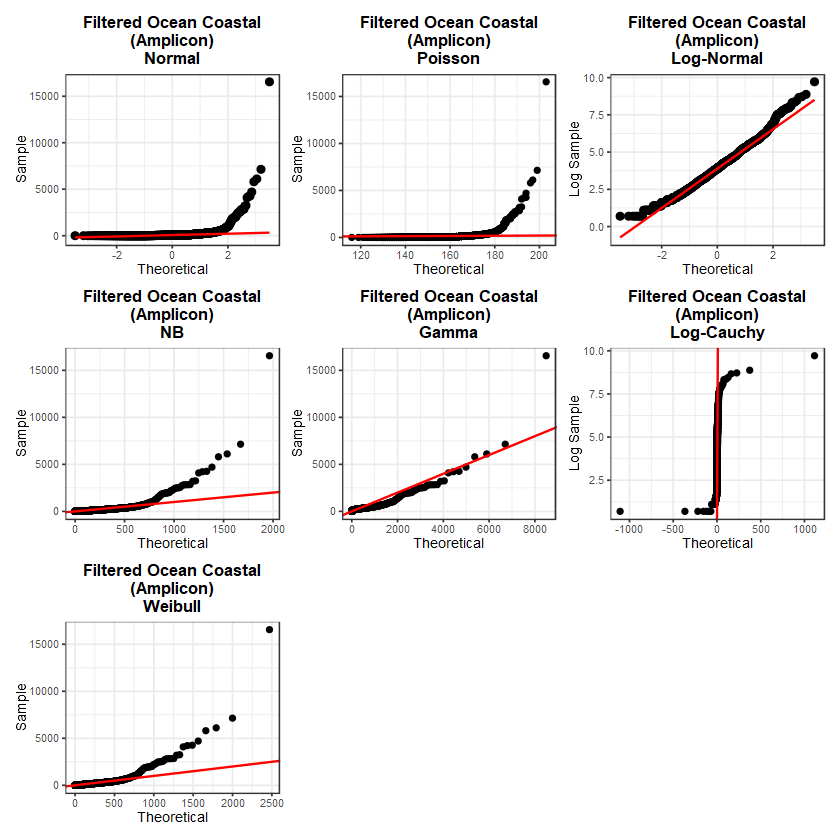

Warning message in sqrt(1/diag(V)):
"NaNs produced"
Warning message in cov2cor(varcovar):
"diag(.) had 0 or NA entries; non-finite result is doubtful"
Warning message in sqrt(diag(varcovar)):
"NaNs produced"


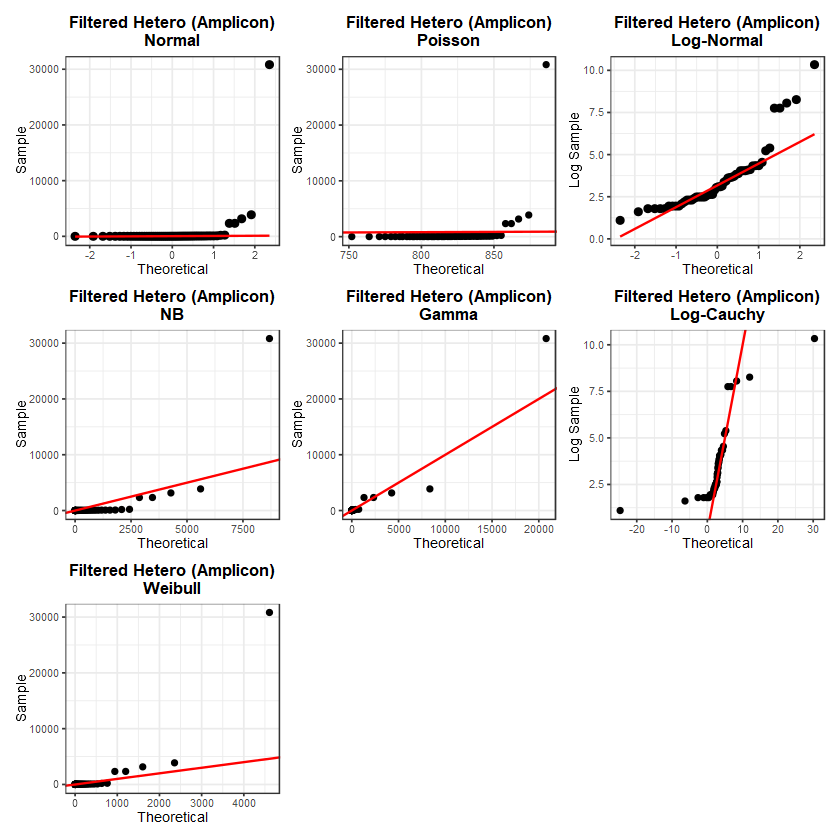

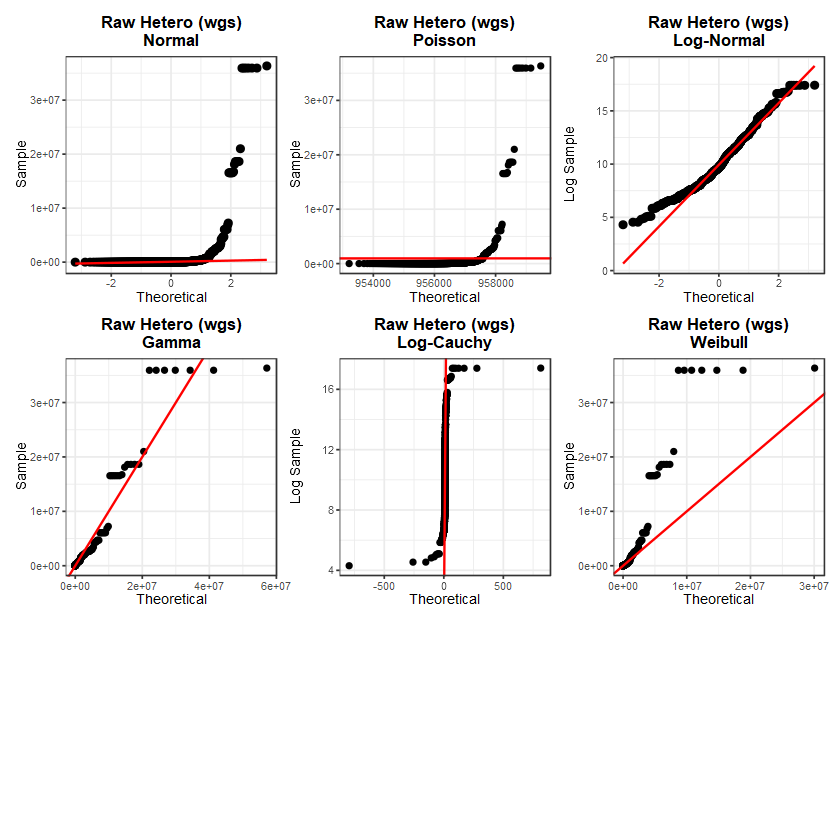

In [17]:
wrap_plots(plot_all_distributions(as.matrix(taxa_od_wgs_filtered), "Filtered Ocean Deep (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(taxa_oc_wgs_filtered), "Filtered Ocean Coastal (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(tax_abund_oc_filtered), "Filtered Ocean Coastal (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(tax_abund_hetero_filtered), "Filtered Hetero (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(tax_abund_hetero_wgs_filtered), "Raw Hetero (wgs)"), ncol = 3, nrow = 3)


# q-q plots for normalized but not filtered data 

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


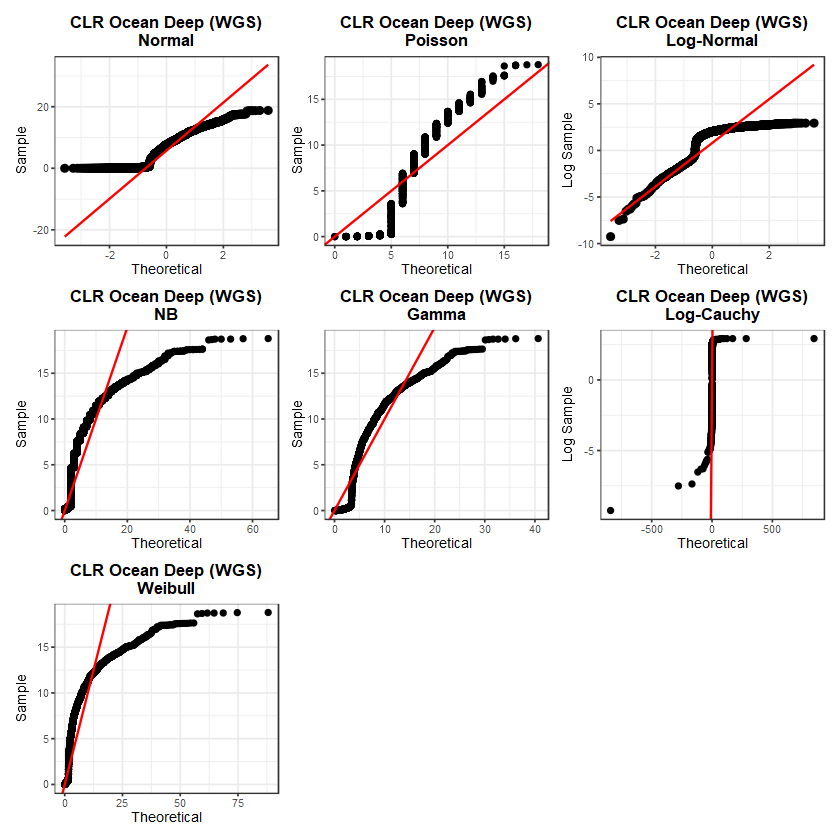

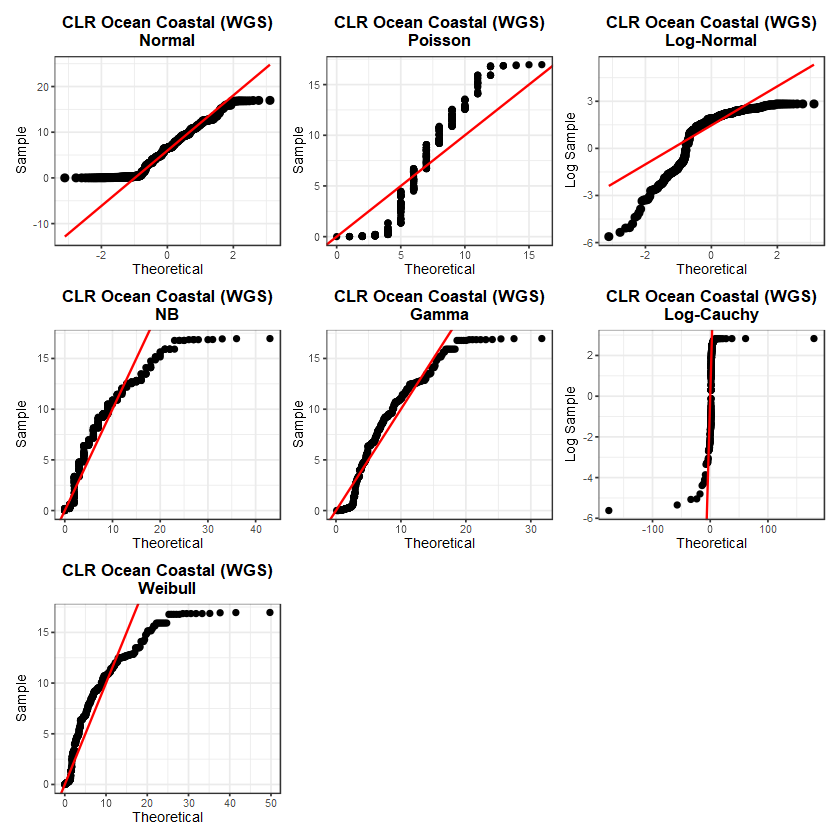

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


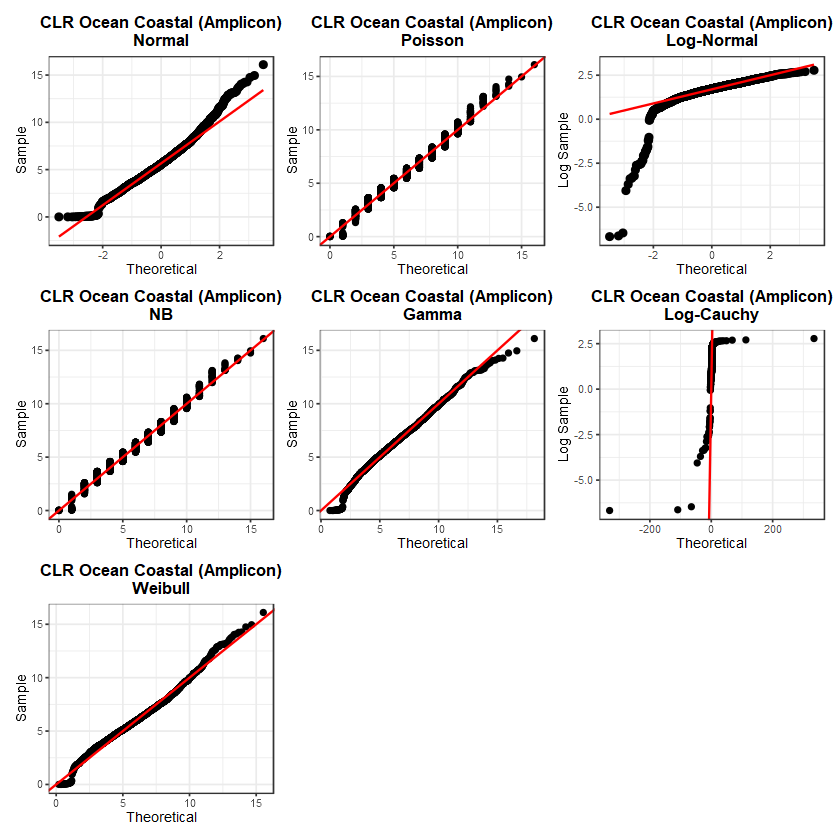

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


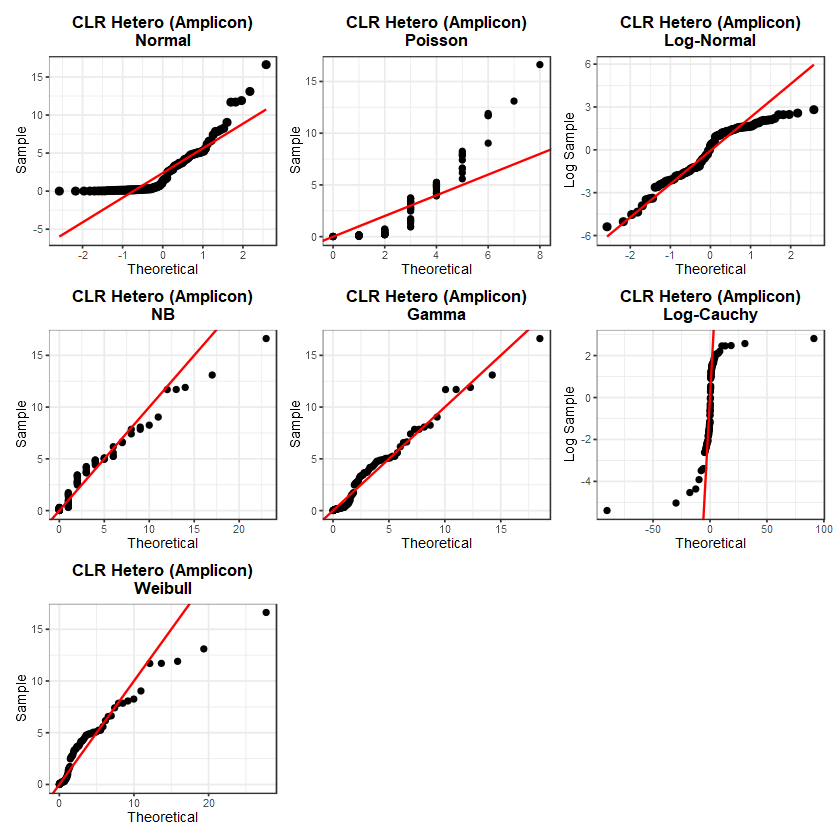

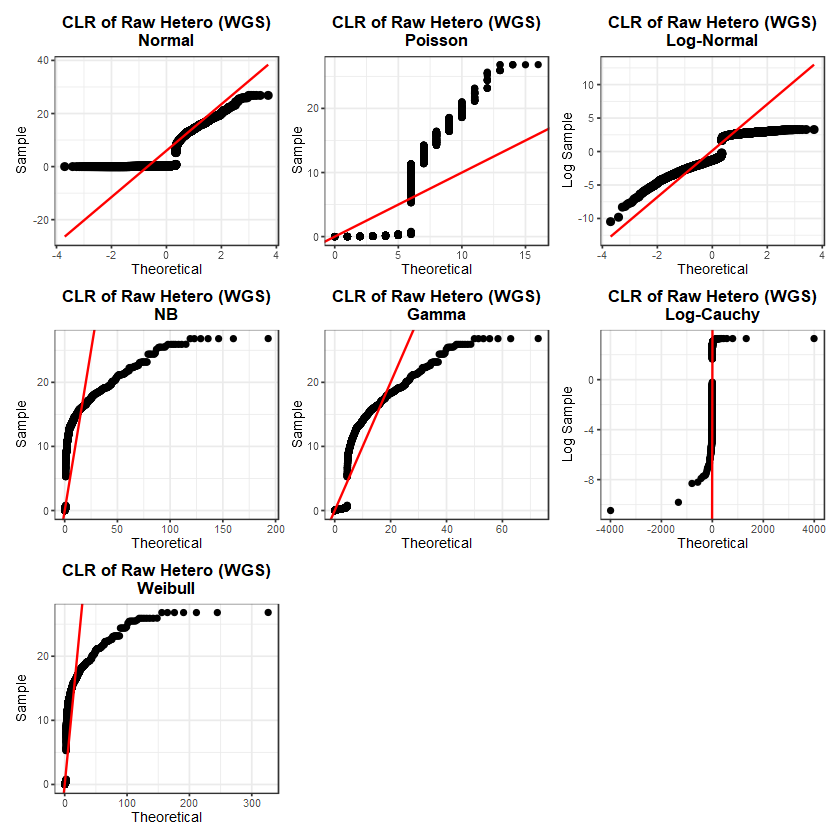

In [19]:
wrap_plots(plot_all_distributions(clr_od_wgs, "CLR Ocean Deep (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_oc_wgs, "CLR Ocean Coastal (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_oc_amplicon, "CLR Ocean Coastal (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_hetero_amplicon, "CLR Hetero (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_hetero_wgs_raw, "CLR of Raw Hetero (WGS)"), ncol = 3, nrow = 3)

# q-q plots for normalized and filtered data

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


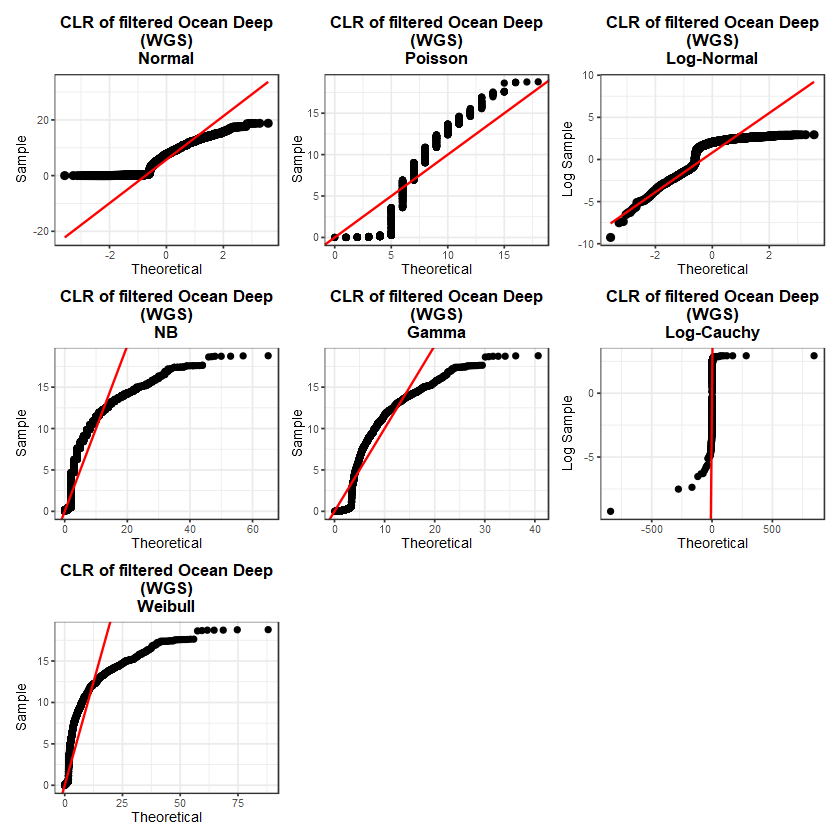

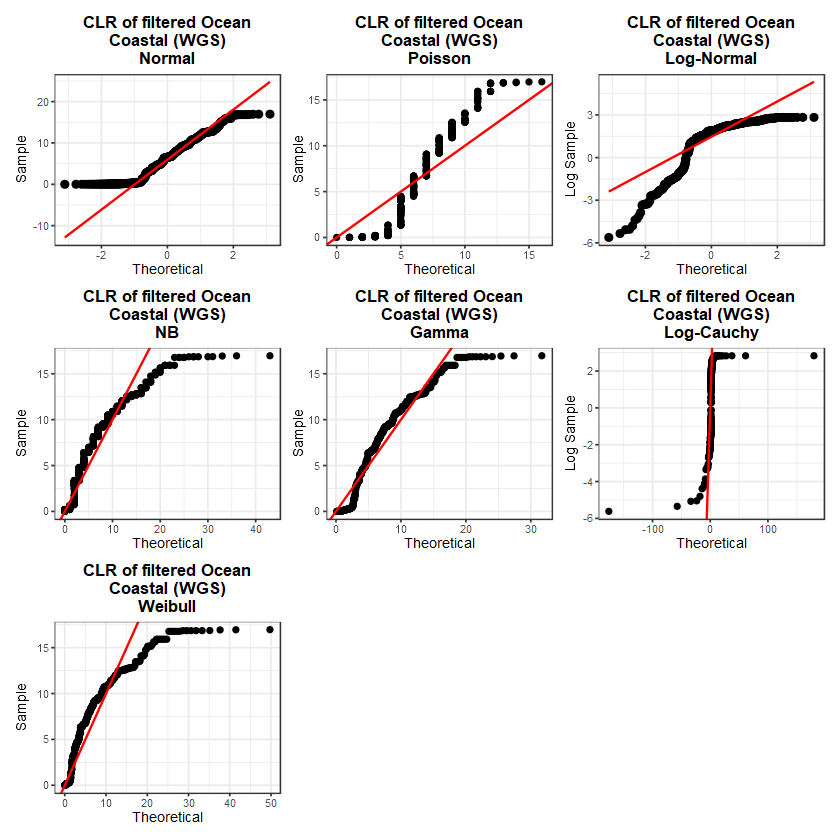

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


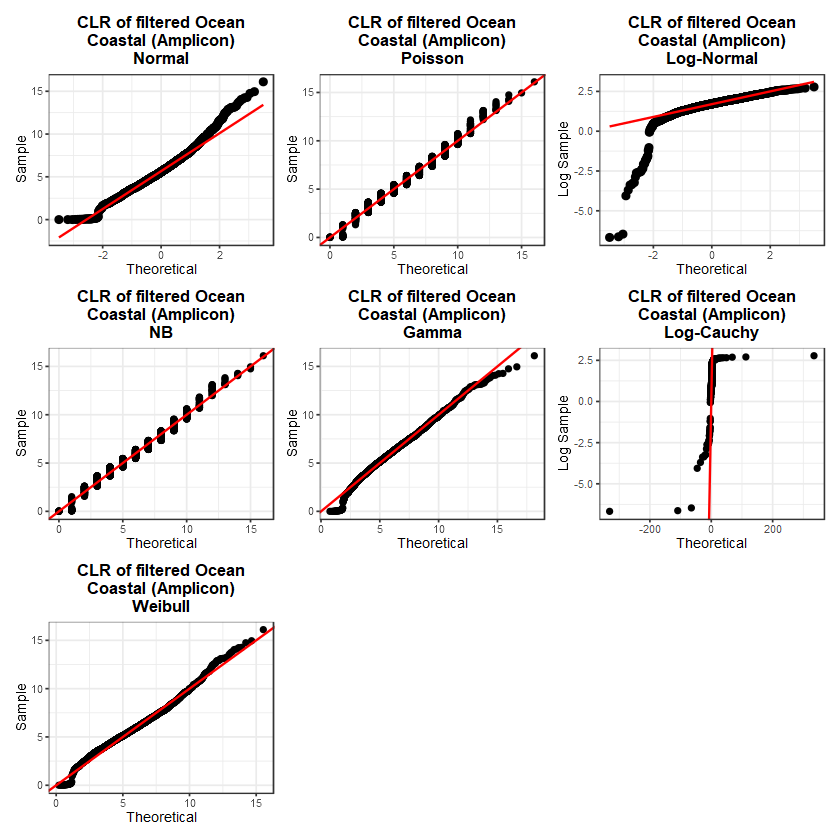

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


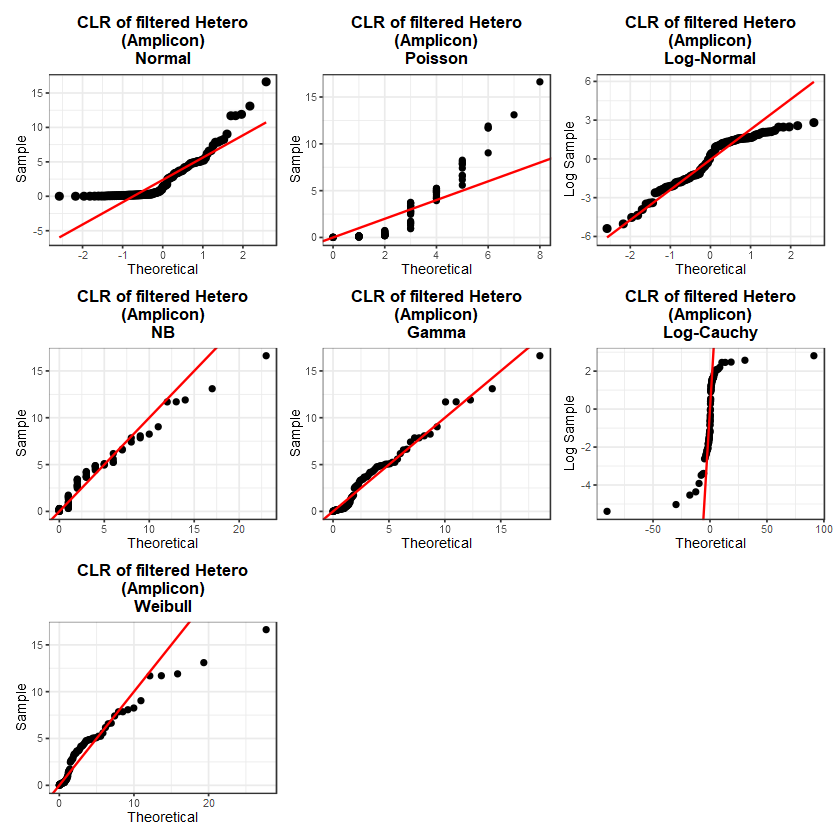

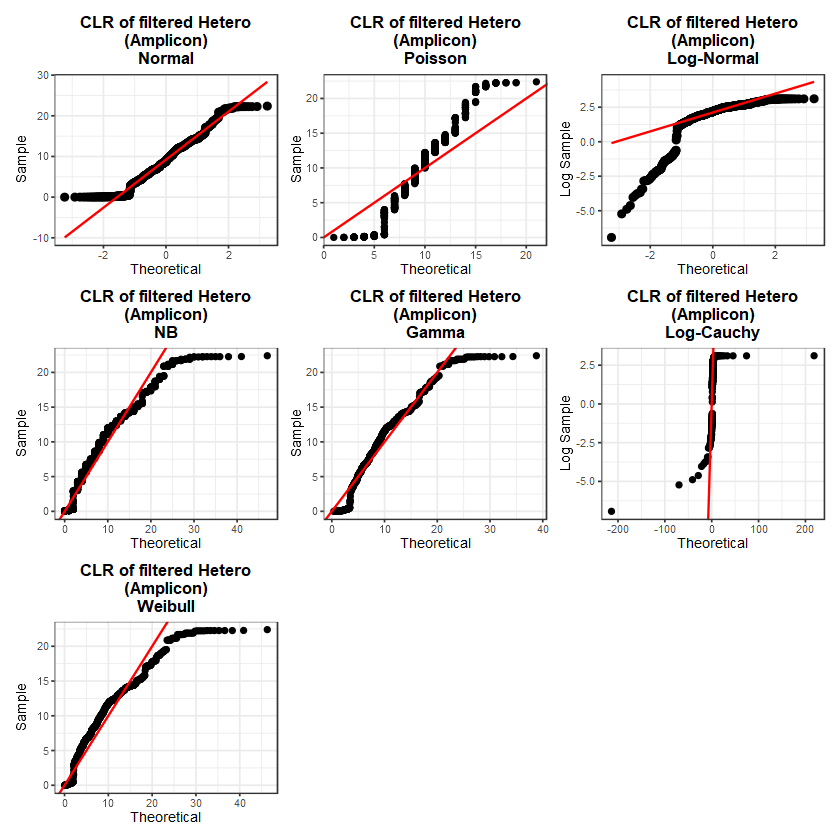

In [21]:
wrap_plots(plot_all_distributions(clr_od_wgs, "CLR of filtered Ocean Deep (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_oc_wgs, "CLR of filtered Ocean Coastal (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_oc_amplicon, "CLR of filtered Ocean Coastal (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_hetero_amplicon, "CLR of filtered Hetero (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_hetero_wgs, "CLR of filtered Hetero (Amplicon)"), ncol = 3, nrow = 3)

In [22]:
perform_ks_tests <- function(data_vector, title_prefix = "") {
  data_vector <- data_vector[!is.na(data_vector)]
  data_vector <- data_vector[data_vector > 0]  # K-S test requires positive values for some distributions
  
  results <- list()
  
  # === Normal ===
  norm_fit <- fitdist(data_vector, "norm")
  results[["Normal"]] <- ks.test(data_vector, "pnorm", mean = norm_fit$estimate["mean"], sd = norm_fit$estimate["sd"])

  # === Log-Normal ===
  log_data <- log(data_vector)
  lnorm_fit <- fitdist(log_data, "norm")
  results[["Log-Normal"]] <- ks.test(log_data, "pnorm", mean = lnorm_fit$estimate["mean"], sd = lnorm_fit$estimate["sd"])

  # === Gamma ===
  gamma_fit <- fitdist(data_vector, "gamma")
  results[["Gamma"]] <- ks.test(data_vector, "pgamma",
                                shape = gamma_fit$estimate["shape"],
                                rate  = gamma_fit$estimate["rate"])

  # === Weibull ===
  weibull_fit <- fitdist(data_vector, "weibull")
  results[["Weibull"]] <- ks.test(data_vector, "pweibull",
                                  shape = weibull_fit$estimate["shape"],
                                  scale = weibull_fit$estimate["scale"])
  
  # === Cauchy ===
  cauchy_fit <- tryCatch({
    fitdist(log(data_vector), "cauchy")
  }, error = function(e) NULL)
  if (!is.null(cauchy_fit)) {
    results[["Log-Cauchy"]] <- ks.test(log(data_vector), "pcauchy",
                                       location = cauchy_fit$estimate["location"],
                                       scale = cauchy_fit$estimate["scale"])
  }

  # === Return as data frame
  ks_df <- do.call(rbind, lapply(names(results), function(name) {
    ks <- results[[name]]
    data.frame(
      Dataset = title_prefix,
      Distribution = name,
      Statistic = ks$statistic,
      PValue = ks$p.value
    )
  }))
  return(ks_df)
}


In [23]:
datasets_list <- list(

  # --- Not Filtered, Not Normalized ---
  "Raw_Ocean_Deep_WGS"     = as.vector(as.matrix(taxa_od_wgs)),
  "Raw_Ocean_Coastal_WGS"  = as.vector(as.matrix(taxa_oc_wgs)),
  "Raw_Ocean_Coastal_Amp"  = as.vector(as.matrix(tax_abund_oc)),
  "Raw_Hetero_Amp"         = as.vector(as.matrix(tax_abund_hetero)),
  "Raw_Hetero_WGS"         = as.vector(as.matrix(taxa_hetero_wgs)),

  # --- Filtered, Not Normalized ---
  "Filt_Ocean_Deep_WGS"    = as.vector(as.matrix(taxa_od_wgs_filtered)),
  "Filt_Ocean_Coastal_WGS" = as.vector(as.matrix(taxa_oc_wgs_filtered)),
  "Filt_Ocean_Coastal_Amp" = as.vector(as.matrix(tax_abund_oc_filtered)),
  "Filt_Hetero_Amp"        = as.vector(as.matrix(tax_abund_hetero_filtered)),
  "Filt_Hetero_WGS"        = as.vector(as.matrix(tax_abund_hetero_wgs_filtered)),

  # --- Normalized (CLR), Not Filtered ---
  "CLR_Ocean_Deep_WGS"     = as.vector(clr_od_wgs_raw),
  "CLR_Ocean_Coastal_WGS"  = as.vector(clr_oc_wgs_raw),
  "CLR_Ocean_Coastal_Amp"  = as.vector(clr_oc_amplicon_raw),
  "CLR_Hetero_Amp"         = as.vector(clr_hetero_amplicon_raw),
  # --- Normalized (CLR), Filtered ---
  "CLR_Filt_Ocean_Deep_WGS"     = as.vector(clr_od_wgs),
  "CLR_Filt_Ocean_Coastal_WGS"  = as.vector(clr_oc_wgs),
  "CLR_Filt_Ocean_Coastal_Amp"  = as.vector(clr_oc_amplicon),
  "CLR_Filt_Hetero_Amp"         = as.vector(clr_hetero_amplicon)
)

# STEP 2: Run K-S tests on each dataset
ks_all_results <- lapply(names(datasets_list), function(name) {
  vec <- datasets_list[[name]]
  perform_ks_tests(vec, title_prefix = name)
})

# STEP 3: Combine into one data frame
ks_all_df <- do.call(rbind, ks_all_results)
ks_all_df$log10_p <- -log10(ks_all_df$PValue)



Warning message in ks.test.default(data_vector, "pnorm", mean = norm_fit$estimate["mean"], :
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test.default(log_data, "pnorm", mean = lnorm_fit$estimate["mean"], :
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test.default(data_vector, "pgamma", shape = gamma_fit$estimate["shape"], :
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test.default(data_vector, "pweibull", shape = weibull_fit$estimate["shape"], :
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test.default(log(data_vector), "pcauchy", location = cauchy_fit$estimate["location"], :
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test.default(data_vector, "pnorm", mean = norm_fit$estimate["mean"], :
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test.default(log_data, "pno

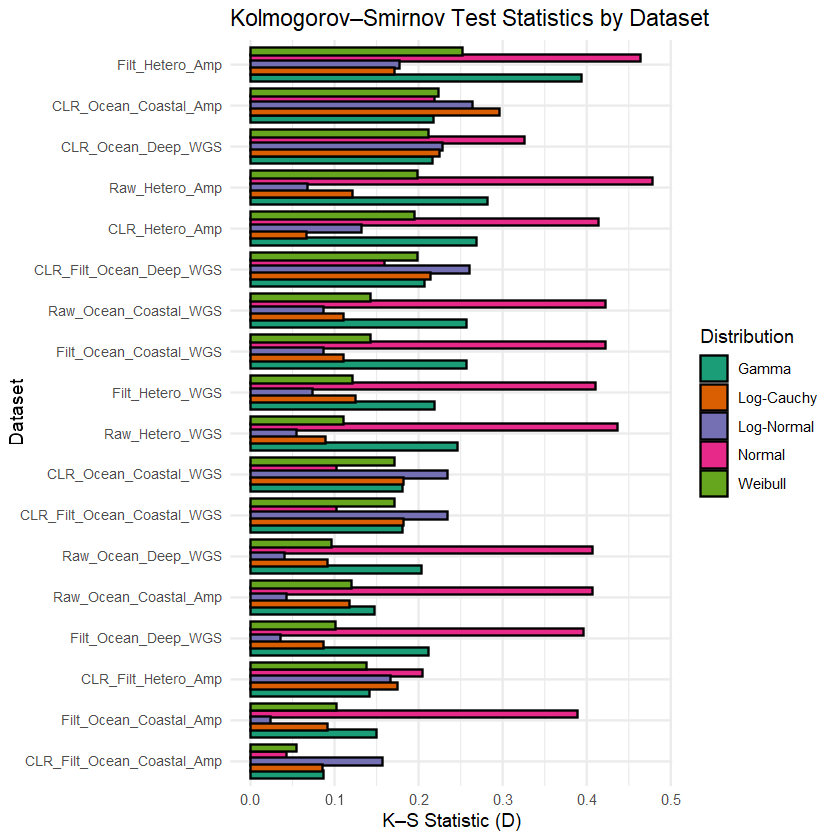

In [24]:
ggplot(ks_all_df, aes(x = reorder(Dataset, Statistic), y = Statistic, fill = Distribution)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.8), color = "black") +
  coord_flip() +
  theme_minimal() +
  scale_fill_brewer(palette = "Dark2") +
  labs(title = "Kolmogorov–Smirnov Test Statistics by Dataset",
       x = "Dataset", y = "K–S Statistic (D)") +
  theme(axis.text.y = element_text(size = 8),
        legend.position = "right")

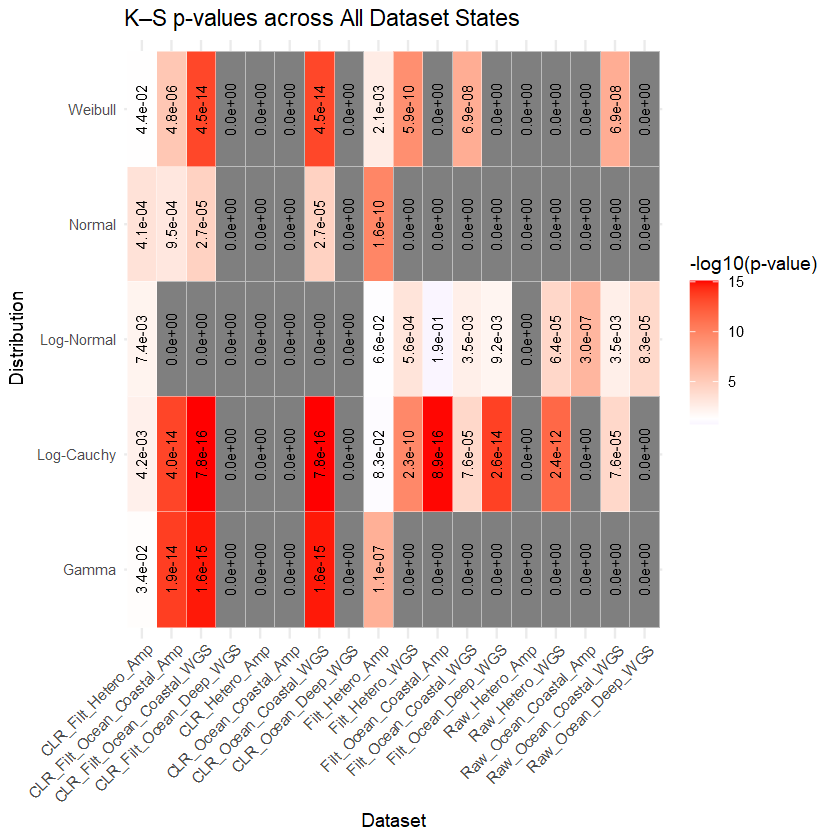

In [25]:
ks_all_df$Label <- sprintf("%.1e", ks_all_df$PValue)

ggplot(ks_all_df, aes(x = Dataset, y = Distribution, fill = log10_p)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Label), angle = 90, size = 3, hjust = 0.5) +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red",
                       midpoint = -log10(0.05), name = "-log10(p-value)") +
  theme_minimal() +
  labs(title = "K–S p-values across All Dataset States",
       x = "Dataset", y = "Distribution") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message:
"Removed 876 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."
Warning message:
"Removed 5657 rows containing missing values or values outside the scale range
(`geom_point()`)."


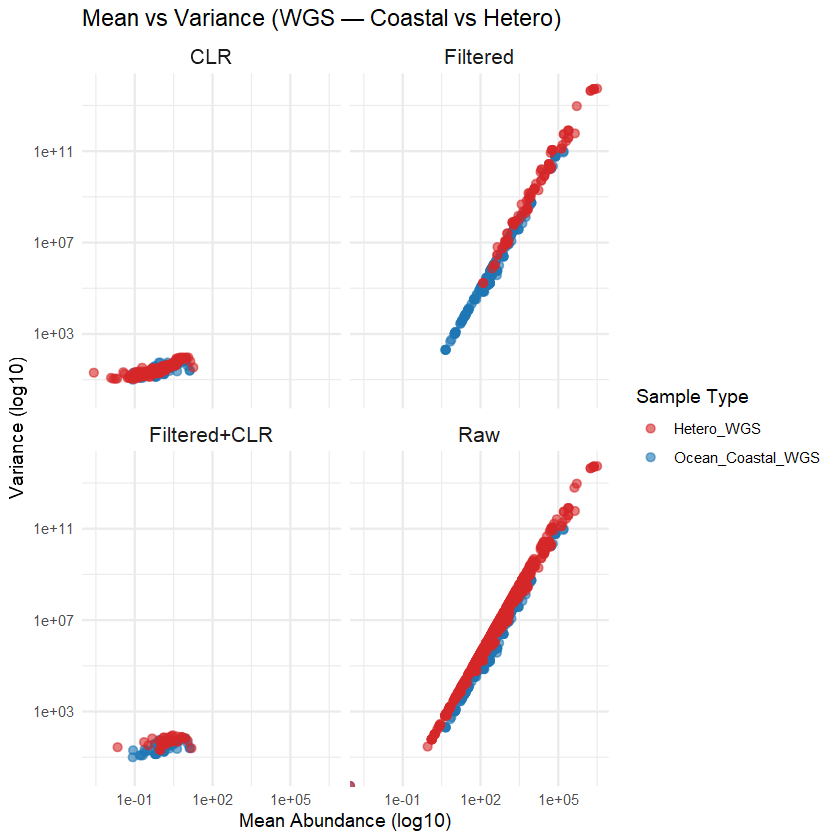

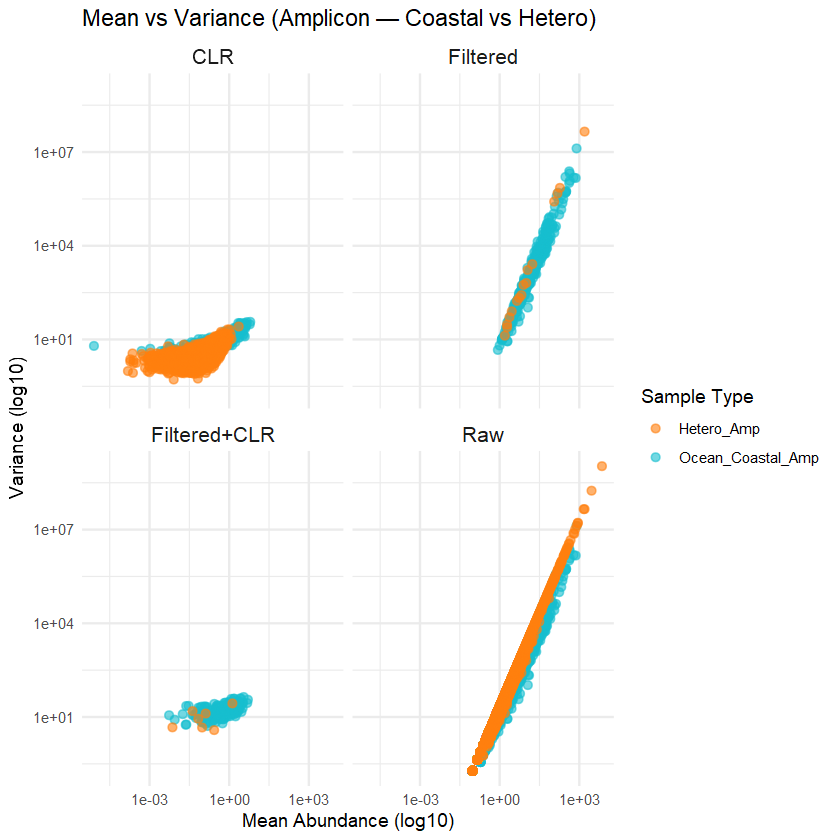

In [26]:
mv_compare_list <- list(

  # 1. Raw (no filtering, no normalization)
  "Raw" = list(
    Ocean_Coastal_WGS     = taxa_oc_wgs,
    Ocean_Coastal_Amp     = tax_abund_oc,
    Hetero_WGS            = taxa_hetero_wgs,
    Hetero_Amp            = tax_abund_hetero
  ),

  # 2. Filtered only
  "Filtered" = list(
    Ocean_Coastal_WGS     = taxa_oc_wgs_filtered,
    Ocean_Coastal_Amp     = tax_abund_oc_filtered,
    Hetero_WGS            = tax_abund_hetero_wgs_filtered,
    Hetero_Amp            = tax_abund_hetero_filtered
  ),

  # 3. CLR only (not filtered)
  "CLR" = list(
    Ocean_Coastal_WGS     = clr_oc_wgs_raw,
    Ocean_Coastal_Amp     = clr_oc_amplicon_raw,
    Hetero_WGS            = clr_hetero_wgs_raw,
    Hetero_Amp            = clr_hetero_amplicon_raw
  ),

  # 4. Filtered + CLR
  "Filtered+CLR" = list(
    Ocean_Coastal_WGS     = clr_oc_wgs,
    Ocean_Coastal_Amp     = clr_oc_amplicon,
    Hetero_WGS            = clr_hetero_wgs,
    Hetero_Amp            = clr_hetero_amplicon
  )
)


# Build long DF with mean/variance + labels
mv_long_df <- do.call(rbind, lapply(names(mv_compare_list), function(condition) {
  inner_list <- mv_compare_list[[condition]]
  do.call(rbind, lapply(names(inner_list), function(label) {
    mat <- as.matrix(inner_list[[label]])
    data.frame(
      Mean = rowMeans(mat, na.rm = TRUE),
      Variance = apply(mat, 1, var, na.rm = TRUE),
      SampleType = label,
      Condition = condition
    )
  }))
}))


# Subset WGS only
mv_wgs_df <- mv_long_df[grepl("WGS", mv_long_df$SampleType), ]

# Subset Amplicon only
mv_amplicon_df <- mv_long_df[grepl("Amp", mv_long_df$SampleType), ]

ggplot(mv_wgs_df, aes(x = Mean, y = Variance, color = SampleType)) +
  geom_point(alpha = 0.6, size = 1.8) +
  scale_x_log10() + scale_y_log10() +
  facet_wrap(~ Condition, ncol = 2) +
  theme_minimal() +
  scale_color_manual(values = c(
    "Ocean_Coastal_WGS" = "#1f77b4",
    "Hetero_WGS" = "#d62728"
  )) +
  labs(title = "Mean vs Variance (WGS — Coastal vs Hetero)",
       x = "Mean Abundance (log10)", y = "Variance (log10)", color = "Sample Type") +
  theme(strip.text = element_text(size = 12))

ggplot(mv_amplicon_df, aes(x = Mean, y = Variance, color = SampleType)) +
  geom_point(alpha = 0.6, size = 1.8) +
  scale_x_log10() + scale_y_log10() +
  facet_wrap(~ Condition, ncol = 2) +
  theme_minimal() +
  scale_color_manual(values = c(
    "Ocean_Coastal_Amp" = "#17becf",
    "Hetero_Amp" = "#ff7f0e"
  )) +
  labs(title = "Mean vs Variance (Amplicon — Coastal vs Hetero)",
       x = "Mean Abundance (log10)", y = "Variance (log10)", color = "Sample Type") +
  theme(strip.text = element_text(size = 12))